In [1]:
import pandas as pd
import os

# Define file path
file_path = '/kaggle/input/cleaned-nvd/cleanen.csv'

# Verify file existence
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Try reading in small chunks to identify problematic lines
chunk_size = 10000  # Read in small batches
encoding_list = ['utf-8', 'latin1', 'ISO-8859-1']

for encoding in encoding_list:
    try:
        print(f"Trying encoding: {encoding}")
        chunk_iterator = pd.read_csv(
            file_path, 
            encoding=encoding, 
            chunksize=chunk_size, 
            engine='python',  # Use 'python' for better error handling
            on_bad_lines='warn'  # Skip problematic lines and warn
        )
        df = pd.concat(chunk_iterator, ignore_index=True)  # Merge chunks
        print(f"Successfully loaded with encoding: {encoding}")
        break  # Exit loop if successful
    except Exception as e:
        print(f"Failed with encoding {encoding}: {e}")

# Display dataset info
print(df.info())
print(df.head())


Trying encoding: utf-8
Successfully loaded with encoding: utf-8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48460 entries, 0 to 48459
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CVE_ID                  48460 non-null  object
 1   Published_Date          48458 non-null  object
 2   Last_Modified_Date      48458 non-null  object
 3   Description             48458 non-null  object
 4   CWE_ID                  48455 non-null  object
 5   Score                   48455 non-null  object
 6   Severity                48455 non-null  object
 7   Attack_Vector           48455 non-null  object
 8   Attack_Complexity       48455 non-null  object
 9   Privileges_Required     48455 non-null  object
 10  User_Interaction        48455 non-null  object
 11  Confidentiality_Impact  48452 non-null  object
 12  Integrity_Impact        48452 non-null  object
 13  Availability_Impact     48452 non-null  ob

In [2]:
import pandas as pd

# Drop rows where critical fields are missing
df_cleaned = df.dropna(subset=['Description', 'Score', 'Severity']).copy()  # Use .copy() to avoid warnings

# Fill missing values in categorical columns with 'UNKNOWN' using .loc
categorical_cols = ['CWE_ID', 'Attack_Vector', 'Attack_Complexity',
                    'Privileges_Required', 'User_Interaction',
                    'Confidentiality_Impact', 'Integrity_Impact', 'Availability_Impact']

df_cleaned.loc[:, categorical_cols] = df_cleaned[categorical_cols].fillna('UNKNOWN')

# Convert 'Score' column to float
df_cleaned.loc[:, 'Score'] = pd.to_numeric(df_cleaned['Score'], errors='coerce')

# Convert Date columns to datetime format
df_cleaned.loc[:, 'Published_Date'] = pd.to_datetime(df_cleaned['Published_Date'], errors='coerce')
df_cleaned.loc[:, 'Last_Modified_Date'] = pd.to_datetime(df_cleaned['Last_Modified_Date'], errors='coerce')

# Drop any remaining NaN values after conversion
df_cleaned = df_cleaned.dropna()

# Display final dataset info
print(df_cleaned.info())
print(df_cleaned.head())


<class 'pandas.core.frame.DataFrame'>
Index: 48452 entries, 0 to 48459
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CVE_ID                  48452 non-null  object
 1   Published_Date          48452 non-null  object
 2   Last_Modified_Date      48452 non-null  object
 3   Description             48452 non-null  object
 4   CWE_ID                  48452 non-null  object
 5   Score                   48452 non-null  object
 6   Severity                48452 non-null  object
 7   Attack_Vector           48452 non-null  object
 8   Attack_Complexity       48452 non-null  object
 9   Privileges_Required     48452 non-null  object
 10  User_Interaction        48452 non-null  object
 11  Confidentiality_Impact  48452 non-null  object
 12  Integrity_Impact        48452 non-null  object
 13  Availability_Impact     48452 non-null  object
dtypes: object(14)
memory usage: 5.5+ MB
None
          CVE_ID  

In [3]:
# Drop unnecessary columns
df = df.drop(['CVE_ID', 'Published_Date', 'Last_Modified_Date'], axis=1, errors='ignore')

# Fill missing values in 'Description'
df['Description'] = df['Description'].fillna('')

# Keep only valid severity levels
df = df[df['Severity'].isin(['LOW', 'MEDIUM', 'HIGH', 'CRITICAL'])]

print("Data cleaning completed successfully!")


Data cleaning completed successfully!


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# ✅ Define target features
target_features = [
    "Severity", "Attack_Complexity", "Privileges_Required", 
    "User_Interaction", "Confidentiality_Impact", 
    "Integrity_Impact", "Availability_Impact"
]

# ✅ Convert 'Description' into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = vectorizer.fit_transform(df["Description"].fillna("")).toarray()

# ✅ Convert to DataFrame
df_tfidf = pd.DataFrame(tfidf_features, columns=[f"tfidf_{i}" for i in range(tfidf_features.shape[1])])

# ✅ Add target labels
for feature in target_features:
    df_tfidf[feature] = df[feature]

# ✅ Include 'Score'
df_tfidf["Score"] = df["Score"]

print(f"TF-IDF feature matrix shape: {df_tfidf.shape}")


TF-IDF feature matrix shape: (48452, 5008)


In [5]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.preprocessing import MinMaxScaler

# ✅ Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load DistilBERT model & tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
bert_model = DistilBertModel.from_pretrained(MODEL_NAME, torch_dtype=torch.float32).to(device)  # ✅ Move to GPU

# ✅ Function to extract BERT embeddings in batches
def get_bert_embeddings_batch(texts, batch_size=64):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT Embeddings (GPU)"):
        batch_texts = [text if text else "empty" for text in texts[i:i + batch_size]]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)  # ✅ Move to GPU
        with torch.no_grad():
            output = bert_model(**tokens)
        embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()  # ✅ Move back to CPU
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# ✅ Apply BERT to the 'Description' column
bert_embeddings = get_bert_embeddings_batch(df["Description"].tolist())

# ✅ Normalize BERT features
scaler = MinMaxScaler()
bert_embeddings_scaled = scaler.fit_transform(bert_embeddings)

# ✅ Convert to DataFrame
df_bert = pd.DataFrame(bert_embeddings_scaled, columns=[f"bert_{i}" for i in range(bert_embeddings_scaled.shape[1])])

# ✅ Ensure df_tfidf exists before merging
if 'df_tfidf' not in locals():
    raise ValueError("TF-IDF features (df_tfidf) not found. Run Step 1 first.")

# ✅ Merge BERT with TF-IDF features
df_combined = pd.concat([df_tfidf.drop(columns=target_features + ["Score"]), df_bert], axis=1)

# ✅ Add target labels
for feature in target_features:
    df_combined[feature] = df_tfidf[feature]

# ✅ Include 'Score'
df_combined["Score"] = df_tfidf["Score"]

print(f"Final combined dataset shape: {df_combined.shape}")



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Extracting BERT Embeddings (GPU): 100%|██████████| 758/758 [03:25<00:00,  3.68it/s]


Final combined dataset shape: (48452, 5776)


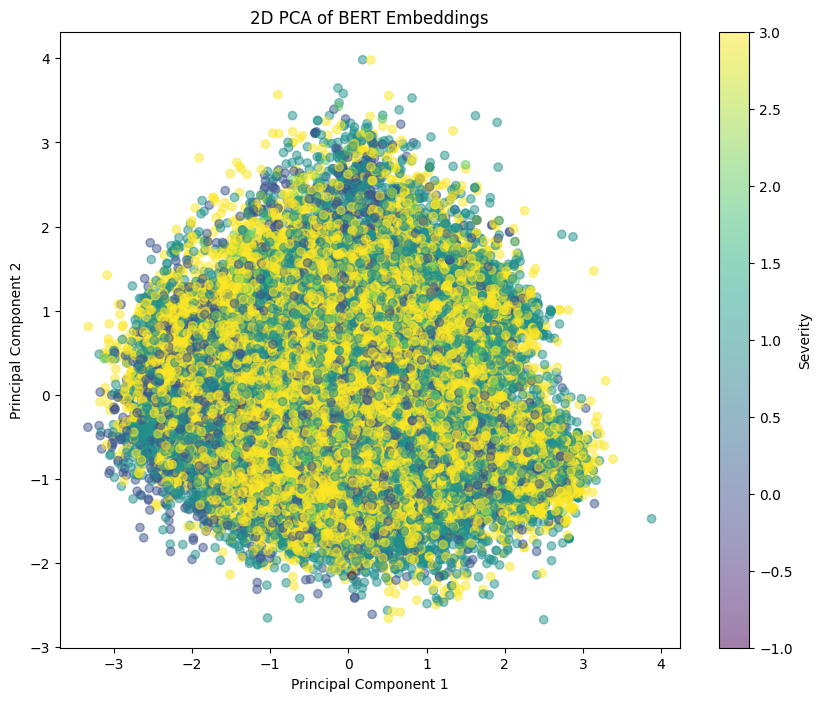

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA to reduce BERT embeddings to 2D
pca = PCA(n_components=2)
bert_embeddings_pca = pca.fit_transform(df_bert)

# Plot the 2D PCA result
plt.figure(figsize=(10, 8))
plt.scatter(bert_embeddings_pca[:, 0], bert_embeddings_pca[:, 1], c=df_tfidf["Severity"].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.colorbar(label='Severity')  # Color by severity (or other target labels)
plt.title('2D PCA of BERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# ✅ Identify categorical columns
categorical_cols = ['Severity', 'Attack_Complexity', 'Privileges_Required', 
                    'User_Interaction', 'Confidentiality_Impact', 
                    'Integrity_Impact', 'Availability_Impact']

# ✅ Encode categorical labels
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_combined[col] = df_combined[col].astype(str)  # Convert to string before encoding
    df_combined[col] = le.fit_transform(df_combined[col])  # Convert to numeric
    label_encoders[col] = le  # Store for inverse transform if needed later

# ✅ Convert dataframe to numeric values
df_combined = df_combined.apply(pd.to_numeric, errors='coerce')  # Force non-numeric to NaN
df_combined.fillna(0, inplace=True)  # Replace NaN with 0

# ✅ Convert dataframe to PyTorch tensors (Use float32 for stability)
X_tensor = torch.tensor(df_combined.drop(columns=categorical_cols).values, dtype=torch.float32, device='cuda')
y_tensor = torch.tensor(df_combined[categorical_cols].values, dtype=torch.int64, device='cuda')

# ✅ Use DataLoader to handle large dataset efficiently
batch_size = 512  # Reduce batch size if OOM persists
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

print(f"✅ Dataset loaded with batch size {batch_size}. Ready for training!")


✅ Dataset loaded with batch size 512. Ready for training!


In [8]:
if 'Severity' in df_combined.columns:
    label_encoder = LabelEncoder()
    df_combined['encoded_labels'] = label_encoder.fit_transform(df_combined['Severity'])
else:
    print("Column 'Severity' not found!")


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import gc
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Convert 'encoded_labels' column properly
df_combined['encoded_labels'] = df_combined['encoded_labels'].apply(
    lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
)
# Encode the 'Severity' column instead of 'encoded_labels'
label_encoder = LabelEncoder()
df_combined['encoded_labels'] = label_encoder.fit_transform(df_combined['Severity'])
# Proceed with the dataset preparation
X = df_combined.drop(columns=['Severity', 'encoded_labels']).values.astype(np.float32)
y = df_combined['encoded_labels'].values.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Step 2: Define Model
class VulnerabilityPredictor(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[512, 256, 128]):
        super(VulnerabilityPredictor, self).__init__()
        self.feature_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.LayerNorm(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.9)
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[0] // 8),
            nn.Tanh(),
            nn.Linear(hidden_dims[0] // 8, 1)
        )
        layers = []
        prev_dim = hidden_dims[0]
        for hidden_dim in hidden_dims[1:]:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        self.classifier = nn.Sequential(*layers)
        self.output_head = nn.Linear(prev_dim, num_classes)
    
    def forward(self, x):
        features = self.feature_layers(x)
        attention_weights = torch.softmax(self.attention(features), dim=1)
        weighted_features = features * attention_weights
        hidden = self.classifier(weighted_features)
        output = self.output_head(hidden)
        return output

# Step 3: Training function
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=15, patience=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    history = {'train_losses': [], 'val_losses': [], 'train_accuracies': [], 'val_accuracies': []}
    counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)"):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        history['val_losses'].append(avg_val_loss)
        history['val_accuracies'].append(val_accuracy)

        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('best_model.pth'))
    return model, history


# Step 4: Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_scores = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)  # This is y_scores
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store values for F1-score
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())  # Store raw logits

    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.2f}%")
    
    return np.array(y_true), np.array(y_scores)

# Step 5: Training and Evaluation
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
model = VulnerabilityPredictor(input_dim, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
trained_model, history = train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=10, patience=3)
accuracy = evaluate_model(trained_model, test_loader, device)

# Cleanup
torch.cuda.empty_cache()
gc.collect()
print("Training complete!")




Epoch 1/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 140.50it/s]


Epoch 1/10 - Train Loss: 1.0391, Train Accuracy: 48.38%, Val Loss: 0.6363, Val Accuracy: 70.37%


Epoch 2/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 182.10it/s]


Epoch 2/10 - Train Loss: 0.6705, Train Accuracy: 71.68%, Val Loss: 0.4927, Val Accuracy: 84.51%


Epoch 3/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 181.64it/s]


Epoch 3/10 - Train Loss: 0.5581, Train Accuracy: 77.21%, Val Loss: 0.3354, Val Accuracy: 91.54%


Epoch 4/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 180.14it/s]


Epoch 4/10 - Train Loss: 0.4873, Train Accuracy: 80.98%, Val Loss: 0.2939, Val Accuracy: 91.68%


Epoch 5/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 184.75it/s]


Epoch 5/10 - Train Loss: 0.4420, Train Accuracy: 83.49%, Val Loss: 0.2468, Val Accuracy: 92.86%


Epoch 6/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 181.97it/s]


Epoch 6/10 - Train Loss: 0.4024, Train Accuracy: 85.36%, Val Loss: 0.2293, Val Accuracy: 93.16%


Epoch 7/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 184.27it/s]


Epoch 7/10 - Train Loss: 0.3874, Train Accuracy: 86.15%, Val Loss: 0.2670, Val Accuracy: 90.64%


Epoch 8/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 178.48it/s]


Epoch 8/10 - Train Loss: 0.3680, Train Accuracy: 86.93%, Val Loss: 0.2135, Val Accuracy: 93.69%


Epoch 9/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 187.35it/s]


Epoch 9/10 - Train Loss: 0.3542, Train Accuracy: 87.66%, Val Loss: 0.1944, Val Accuracy: 94.20%


Epoch 10/10 (Train): 100%|██████████| 258/258 [00:01<00:00, 184.36it/s]
<ipython-input-9-d3b99e6f9d02>:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_di

Epoch 10/10 - Train Loss: 0.3370, Train Accuracy: 88.29%, Val Loss: 0.1905, Val Accuracy: 93.86%
Test Loss: 0.1893, Accuracy: 94.08%
Training complete!


In [10]:
from sklearn.metrics import accuracy_score, f1_score

# Get true labels and model predictions
y_true, y_scores = evaluate_model(trained_model, test_loader, device)

# Convert raw logits to class predictions
y_pred = np.argmax(y_scores, axis=1)

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute F1-Score (Macro and Weighted for Multi-Class)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Macro F1-Score: {f1_macro:.4f}")
print(f"✅ Weighted F1-Score: {f1_weighted:.4f}")


Test Loss: 0.1893, Accuracy: 94.08%
✅ Test Accuracy: 94.08%
✅ Macro F1-Score: 0.7096
✅ Weighted F1-Score: 0.9324


In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report
import numpy as np

# Get true labels and model predictions
y_true, y_scores = evaluate_model(trained_model, test_loader, device)

# Convert raw logits to class predictions
y_pred = np.argmax(y_scores, axis=1)

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute F1-Score (Macro and Weighted for Multi-Class)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Compute Precision (Macro and Weighted)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Generate Classification Report
class_report = classification_report(y_true, y_pred, target_names=["LOW", "MEDIUM", "HIGH", "CRITICAL"])

# Print Results
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Macro F1-Score: {f1_macro:.4f}")
print(f"✅ Weighted F1-Score: {f1_weighted:.4f}")
print(f"✅ Macro Precision: {precision_macro:.4f}")
print(f"✅ Weighted Precision: {precision_weighted:.4f}")
print("\n📊 Classification Report:\n")
print(class_report)


Test Loss: 0.1893, Accuracy: 94.08%
✅ Test Accuracy: 94.08%
✅ Macro F1-Score: 0.7096
✅ Weighted F1-Score: 0.9324
✅ Macro Precision: 0.7104
✅ Weighted Precision: 0.9253

📊 Classification Report:

              precision    recall  f1-score   support

         LOW       0.97      0.91      0.94      1320
      MEDIUM       0.91      0.99      0.95      3793
        HIGH       0.00      0.00      0.00       171
    CRITICAL       0.96      0.95      0.95      4407

    accuracy                           0.94      9691
   macro avg       0.71      0.71      0.71      9691
weighted avg       0.93      0.94      0.93      9691



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

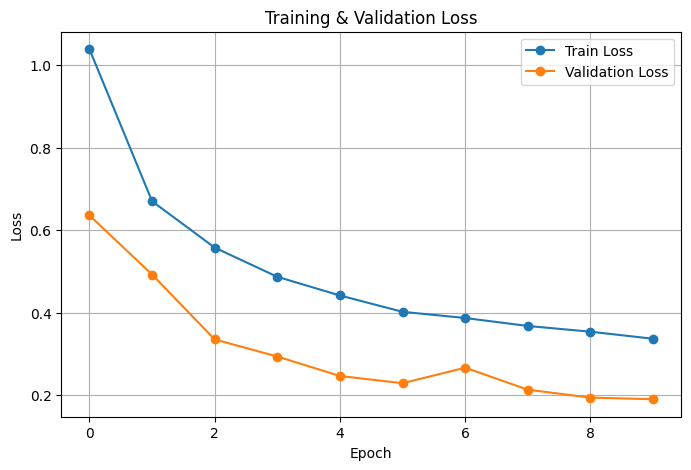

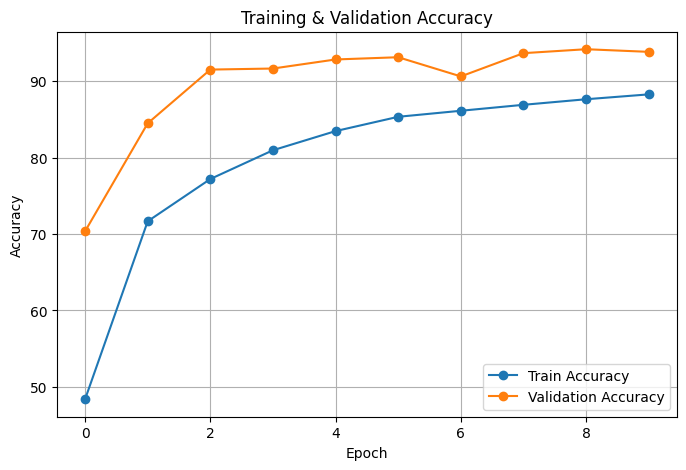

In [12]:
# Plot Training Loss & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history['train_losses'], label='Train Loss', marker='o')
plt.plot(history['val_losses'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Accuracy & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history['train_accuracies'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracies'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


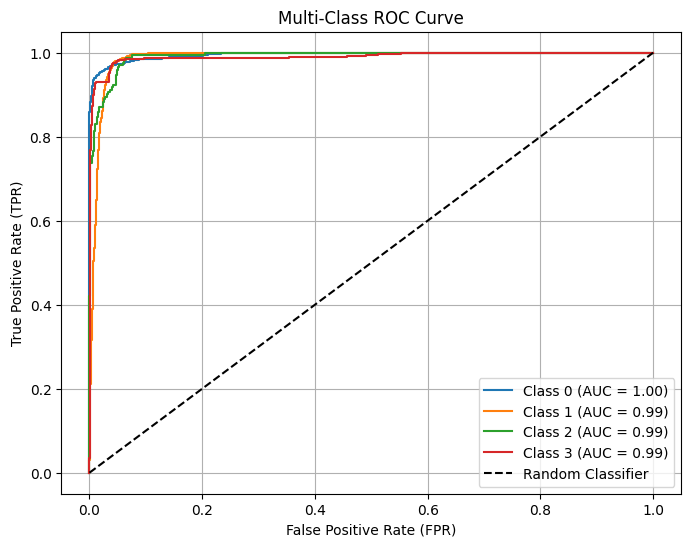

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Get model predictions
model.eval()
y_true = []
y_scores = []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)  # Get raw logits
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        y_scores.extend(probabilities)
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Binarize labels for multi-class ROC computation
y_bin = label_binarize(y_true, classes=np.unique(y_true))

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

